# Imports

In [1]:
# Torch
import torch
import torchvision
import torch.nn as nn
from torchvision import datasets, transforms

# Wandb
import wandb

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Seeding
torch.manual_seed(24)

# Scheduler
from torch.optim.lr_scheduler import StepLR

# GPU/CPU

In [2]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [3]:
# Get device
device = get_default_device()

In [4]:
device

device(type='cpu')

# Datasets

### Helpers

In [5]:
# Imports
import os
import cv2
import numpy as np

def load_images_from_folder(path, skip=1):
    # List of images
    images = []
    
    # Read every 3rd file
    folder = os.listdir(path)
    
    # Read and skip
    for x in range(0, len(folder), skip):
        # Read image
        img = cv2.imread(os.path.join(path,folder[x]))
        
        if img is not None:
            # Resize image
            resized = cv2.resize(img, (32, 32), interpolation = cv2.INTER_AREA)
            images.append(resized)
            
    return images

def mixup_data(x, y, alpha=1.0, use_cuda=True):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if torch.cuda.is_available():
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

### Load

In [6]:
# Transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load dataset
dataset = datasets.ImageFolder("./dataset/train/", transform=transform)

In [7]:
# Labels
class_names = dataset.classes[1:]

In [8]:
class_names

['0', '1']

In [9]:
# Create train and val
batch_size = 32
val_size = int(0.25 * len(dataset))
train_size = len(dataset) - val_size

# Create train and validation
trainset, validationset = torch.utils.data.random_split(dataset, [train_size, val_size])

In [10]:
print(len(trainset), len(validationset))

1122 373


### DataLoaders

In [11]:
# Loaders
train_loader = torch.utils.data.DataLoader(trainset, batch_size, shuffle=True,)
validation_loader = torch.utils.data.DataLoader(validationset, batch_size, shuffle=True)

### Visualize Images

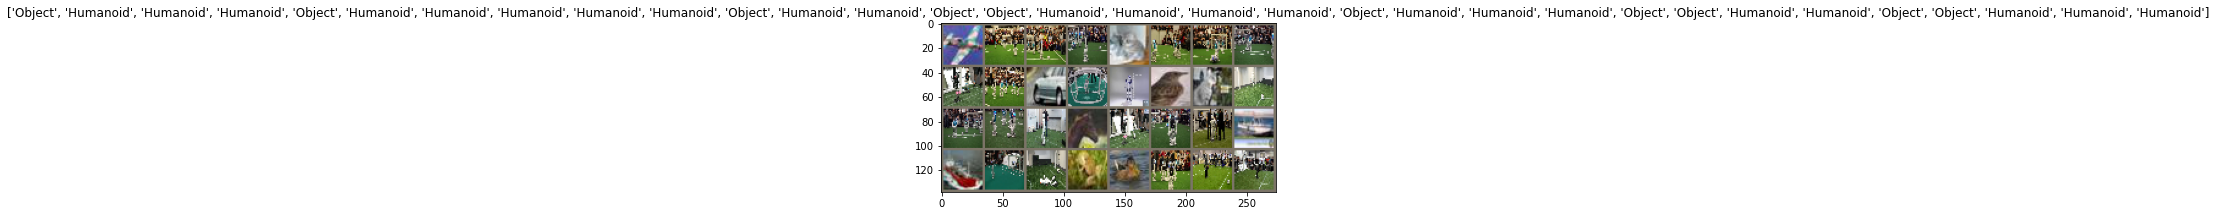

In [18]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_loader))

class_names = {1: "Object", 2: "Humanoid"}

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

title=[class_names[x.item()] for x in classes]

imshow(out, title)